# Professor Review Star Predictor

## 1. Setup

In [1]:
import requests
import pandas as pd
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, Subset
from torch.nn import CrossEntropyLoss

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Data Collection

We'll fetch reviews from the Planet Terp API for 5 UMD professors.

In [2]:
def fetch_reviews(professors):
    """Fetch reviews for a list of professors from Planet Terp API."""

    all_reviews = []
    base_url = "https://api.planetterp.com/v1/professor"

    for prof_name in professors:
        print(f"Fetching reviews for {prof_name}...")
        try:
            response = requests.get(base_url, params={'name': prof_name, 'reviews': 'true'})

            if response.status_code == 200:
                prof_data = response.json()

                if 'reviews' in prof_data:
                    reviews = prof_data['reviews']
                    print(f"  Found {len(reviews)} reviews")

                    for review in reviews:
                        if 'review' in review and 'rating' in review:
                            all_reviews.append({
                                'professor': prof_name,
                                'review_text': review['review'],
                                'rating': int(review['rating'])
                            })
                else:
                    print(f"  No reviews found")
            else:
                print(f"  API error: {response.status_code}")

        except Exception as e:
            print(f"  Error: {e}")

        time.sleep(1)

    return pd.DataFrame(all_reviews)

In [3]:
# Fetch data
professors = [
    "Nelson Padua-Perez",
    "Justin Wyss-Gallifent",
    "Elias Gonzalez",
    "Clyde Kruskal",
    "Anwar Mamat"
]

df = fetch_reviews(professors)
print()
print(f"Total reviews collected: {len(df)}")

Fetching reviews for Nelson Padua-Perez...
  Found 241 reviews
Fetching reviews for Justin Wyss-Gallifent...
  Found 322 reviews
Fetching reviews for Elias Gonzalez...
  Found 88 reviews
Fetching reviews for Clyde Kruskal...
  Found 100 reviews
Fetching reviews for Anwar Mamat...
  Found 71 reviews

Total reviews collected: 822


## 3. Exploratory Data Analysis

In [4]:
# Basic stats
print("Dataset shape:", df.shape)
print()
print("First few rows:")
df.head()

Dataset shape: (822, 3)

First few rows:


,professor,review_text,rating
0,Nelson Padua-Perez,Nelson is a great guy! His personality is so n...,4
1,Nelson Padua-Perez,Nelson is absolutely and unequivocally the wor...,1
2,Nelson Padua-Perez,People told me Nelson was awesome before I cho...,3
3,Nelson Padua-Perez,Nelson is a wonderfully funny professor who re...,5
4,Nelson Padua-Perez,"In my opinion, Nelson is a solid CS professor....",4


In [5]:
# Check for missing values
print("Missing values:")
print(df.isna().sum())

# Filter out empty reviews
df = df[df['review_text'].notna() & (df['review_text'] != "")]
df = df[(df['rating'] >= 1) & (df['rating'] <= 5)]

print()
print(f"After cleaning: {len(df)} reviews")

Missing values:
professor      0
review_text    0
rating         0
dtype: int64

After cleaning: 822 reviews


/tmp/ipython-input-2705489092.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prof_counts.index, y=prof_counts.values, palette='viridis')


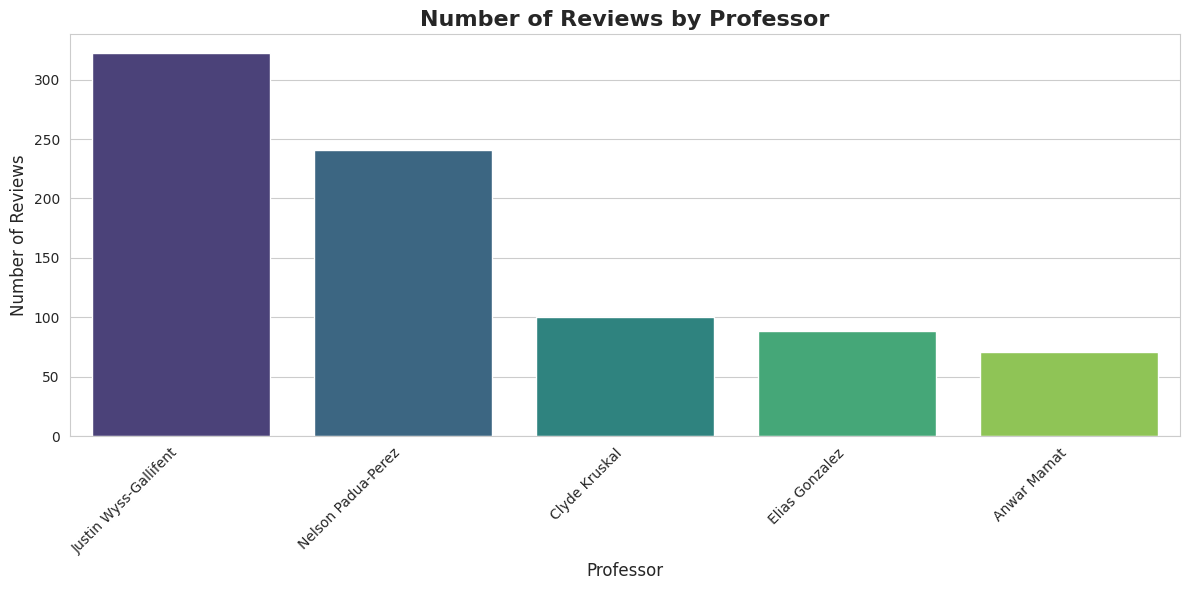


Reviews per professor:
professor
Justin Wyss-Gallifent    322
Nelson Padua-Perez       241
Clyde Kruskal            100
Elias Gonzalez            88
Anwar Mamat               71
Name: count, dtype: int64


In [6]:
# Visualization 1: Reviews by Professor
plt.figure(figsize=(12, 6))
prof_counts = df['professor'].value_counts()
sns.barplot(x=prof_counts.index, y=prof_counts.values, palette='viridis')
plt.title('Number of Reviews by Professor', fontsize=16, fontweight='bold')
plt.xlabel('Professor', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('reviews_by_professor.png')
plt.show()

print()
print("Reviews per professor:")
print(prof_counts)

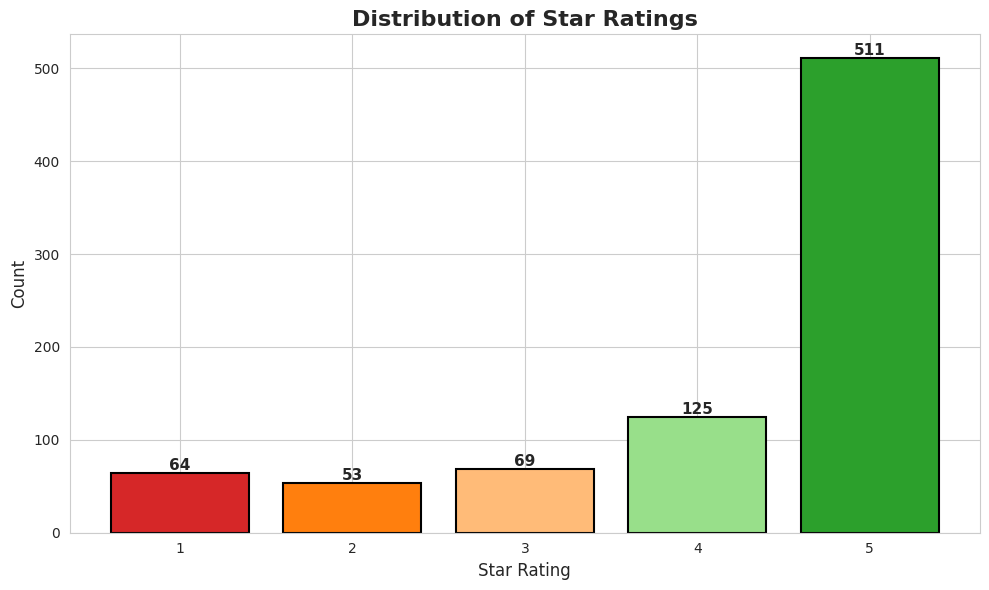


Rating distribution:
rating
1     64
2     53
3     69
4    125
5    511
Name: count, dtype: int64

Class imbalance: 5-star reviews are 9.6x more common than 2-star reviews


In [7]:
# Visualization 2: Star Rating Distribution
plt.figure(figsize=(10, 6))
rating_counts = df['rating'].value_counts().sort_index()
colors = ['#d62728', '#ff7f0e', '#ffbb78', '#98df8a', '#2ca02c']
bars = plt.bar(rating_counts.index, rating_counts.values, color=colors, edgecolor='black', linewidth=1.5)

plt.title('Distribution of Star Ratings', fontsize=16, fontweight='bold')
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([1, 2, 3, 4, 5])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('star_rating.png')
plt.show()

print()
print("Rating distribution:")
print(rating_counts)
print()
print(f"Class imbalance: 5-star reviews are {rating_counts[5] / rating_counts[2]:.1f}x more common than 2-star reviews")

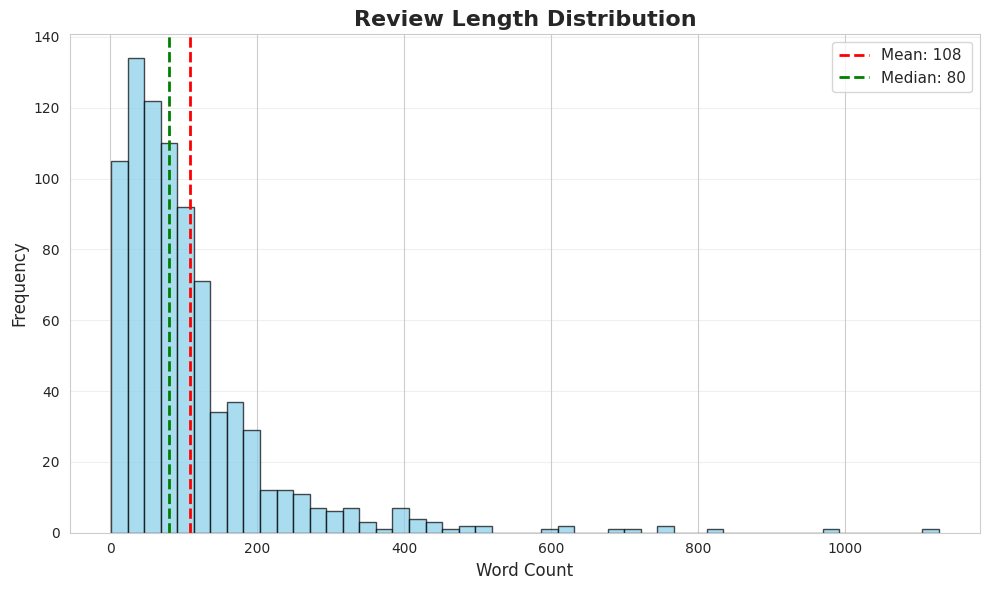

<Figure size 1000x600 with 0 Axes>

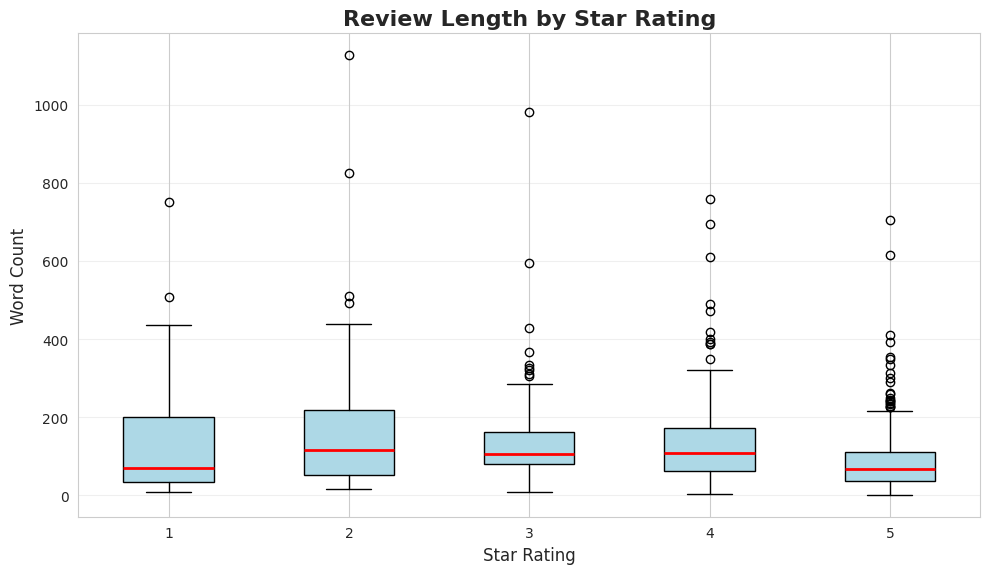


Review length statistics:
count     822.000000
mean      107.992701
std       114.291121
min         1.000000
25%        41.000000
50%        80.000000
75%       131.750000
max      1127.000000
Name: word_count, dtype: float64


In [8]:
df['word_count'] = df['review_text'].apply(lambda x: len(x.split()))

# Visualization 3a: Review Length Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(df['word_count'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["word_count"].mean():.0f}')
plt.axvline(df['word_count'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["word_count"].median():.0f}')
plt.title('Review Length Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('review_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 3b: Review Length by Star Rating
plt.figure(figsize=(10, 6))
df.boxplot(column='word_count', by='rating', patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='black'),
           medianprops=dict(color='red', linewidth=2),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'))
plt.title('Review Length by Star Rating', fontsize=16, fontweight='bold')
plt.suptitle('')
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('review_length_by_rating.png', dpi=300, bbox_inches='tight')
plt.show()

print()
print("Review length statistics:")
print(df['word_count'].describe())

## 4. Data Preprocessing

In [9]:
# Create labels (0-4 instead of 1-5 for model compatibility)
df['label'] = df['rating'] - 1

# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Based on our analysis, use max_length=256 to cover most reviews
MAX_LENGTH = 256

all_texts = df['review_text'].tolist()
all_labels = df['label'].tolist()

all_encodings = tokenizer(all_texts, truncation=True, padding=True, max_length=MAX_LENGTH)

print(f"Tokenized {len(all_texts)} reviews with max_length={MAX_LENGTH}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenized 822 reviews with max_length=256


In [10]:
# PyTorch Dataset
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

full_dataset = ReviewDataset(all_encodings, all_labels)
print(f"Created dataset with {len(full_dataset)} samples")

Created dataset with 822 samples


## 5. Model Training - Experiment 1: Baseline (3 Epochs)

Let's start with a simple baseline: 3 epochs, no class weighting.

In [11]:
def compute_metrics(pred):
    """Calculate evaluation metrics."""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def run_cross_validation(num_epochs=3, use_class_weights=False, experiment_name="baseline"):
    """Run 5-fold cross-validation."""
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []
    best_accuracy = 0.0
    best_model_path = None

    print()
    print(f"{'='*60}")
    print(f"Experiment: {experiment_name}")
    print(f"Epochs: {num_epochs}, Class Weights: {use_class_weights}")
    print(f"{'='*60}")
    print()

    for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
        print(f"Fold {fold + 1}/5...")

        train_sub = Subset(full_dataset, train_idx)
        val_sub = Subset(full_dataset, val_idx)

        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

        training_args = TrainingArguments(
            output_dir=f'./results_{experiment_name}/fold_{fold}',
            num_train_epochs=num_epochs,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=64,
            warmup_steps=20,
            weight_decay=0.01,
            logging_dir=f'./logs_{experiment_name}/fold_{fold}',
            logging_steps=10,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            report_to="none"
        )

        if use_class_weights:
            # Custom trainer with class weights
            class_weights = compute_class_weight(
                class_weight='balanced',
                classes=np.unique(all_labels),
                y=all_labels
            )
            class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

            class WeightedTrainer(Trainer):
                def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
                    labels = inputs.pop("labels")
                    outputs = model(**inputs)
                    logits = outputs.logits
                    loss_fct = CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
                    loss = loss_fct(logits, labels)
                    return (loss, outputs) if return_outputs else loss

            trainer = WeightedTrainer(
                model=model,
                args=training_args,
                train_dataset=train_sub,
                eval_dataset=val_sub,
                compute_metrics=compute_metrics
            )
        else:
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_sub,
                eval_dataset=val_sub,
                compute_metrics=compute_metrics
            )

        trainer.train()
        eval_result = trainer.evaluate()
        results.append(eval_result)

        if eval_result['eval_accuracy'] > best_accuracy:
            best_accuracy = eval_result['eval_accuracy']
            model_path = f"./best_model_{experiment_name}"
            trainer.save_model(model_path)
            best_model_path = model_path
            print(f"  New best: {best_accuracy:.4f}")

    avg_acc = np.mean([res['eval_accuracy'] for res in results])
    avg_f1 = np.mean([res['eval_f1'] for res in results])

    print()
    print(f"Results: Avg Accuracy = {avg_acc:.4f}, Avg F1 = {avg_f1:.4f}")

    return {
        'experiment': experiment_name,
        'avg_accuracy': avg_acc,
        'avg_f1': avg_f1,
        'best_accuracy': best_accuracy,
        'best_model_path': best_model_path,
        'fold_results': results
    }

In [12]:
# Experiment 1: 3 epochs, no class weights
exp1_results = run_cross_validation(num_epochs=3, use_class_weights=False, experiment_name="3epochs_baseline")


Experiment: 3epochs_baseline
Epochs: 3, Class Weights: False

Fold 1/5...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.056500,1.029643,0.587879,0.435300,0.345601,0.587879
2,0.822800,0.804581,0.666667,0.592895,0.576751,0.666667
3,0.585400,0.751457,0.709091,0.662973,0.635970,0.709091


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  New best: 0.7091
Fold 2/5...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.177900,1.008506,0.654545,0.517882,0.428430,0.654545
2,0.995500,0.897053,0.654545,0.556061,0.484193,0.654545
3,0.677700,0.819297,0.684848,0.641622,0.613578,0.684848


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3/5...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.231700,1.046873,0.634146,0.492173,0.402142,0.634146
2,0.776000,0.796288,0.682927,0.621147,0.574213,0.682927
3,0.660300,0.744889,0.707317,0.655564,0.613526,0.707317


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4/5...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.212500,1.081184,0.634146,0.492173,0.402142,0.634146
2,0.823600,0.871148,0.664634,0.627169,0.619590,0.664634
3,0.610100,0.813762,0.719512,0.668958,0.627645,0.719512


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  New best: 0.7195
Fold 5/5...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.106600,1.291586,0.597561,0.447030,0.357079,0.597561
2,0.845700,0.837406,0.713415,0.650028,0.597783,0.713415
3,0.763700,0.796747,0.689024,0.649623,0.639159,0.689024


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Results: Avg Accuracy = 0.7020, Avg F1 = 0.6557


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 6. Model Training - Experiment 2: More Epochs (5 Epochs)

In [ ]:
# Experiment 2: 5 epochs, no class weights
exp2_results = run_cross_validation(num_epochs=5, use_class_weights=False, experiment_name="5epochs_baseline")


Experiment: 5epochs_baseline
Epochs: 5, Class Weights: False

Fold 1/5...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.103300,1.143341,0.587879,0.435300,0.345601,0.587879
2,0.868300,0.887038,0.630303,0.517379,0.439349,0.630303
3,0.602000,0.751500,0.684848,0.644351,0.629672,0.684848
4,0.541900,0.750448,0.709091,0.681629,0.667273,0.709091
5,0.339600,0.728718,0.696970,0.658385,0.633388,0.696970


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  New best: 0.6970
Fold 2/5...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.142600,1.057637,0.587879,0.565714,0.565164,0.587879
2,0.920200,0.928782,0.642424,0.573297,0.525007,0.642424
3,0.642500,0.914160,0.672727,0.632930,0.606339,0.672727
4,0.443700,0.904631,0.672727,0.642913,0.618911,0.672727


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

## 7. Model Training - Experiment 3: Class Weighting

In [ ]:
# Experiment 3: 5 epochs WITH class weights
exp3_results = run_cross_validation(num_epochs=5, use_class_weights=True, experiment_name="5epochs_weighted")

## 8. Experiment Comparison

In [ ]:
# Comparison table
comparison_df = pd.DataFrame([
    {
        'Experiment': exp1_results['experiment'],
        'Avg Accuracy': f"{exp1_results['avg_accuracy']:.4f}",
        'Avg F1': f"{exp1_results['avg_f1']:.4f}",
        'Best Fold Accuracy': f"{exp1_results['best_accuracy']:.4f}"
    },
    {
        'Experiment': exp2_results['experiment'],
        'Avg Accuracy': f"{exp2_results['avg_accuracy']:.4f}",
        'Avg F1': f"{exp2_results['avg_f1']:.4f}",
        'Best Fold Accuracy': f"{exp2_results['best_accuracy']:.4f}"
    },
    {
        'Experiment': exp3_results['experiment'],
        'Avg Accuracy': f"{exp3_results['avg_accuracy']:.4f}",
        'Avg F1': f"{exp3_results['avg_f1']:.4f}",
        'Best Fold Accuracy': f"{exp3_results['best_accuracy']:.4f}"
    }
])

print("\n" + "="*70)
print("EXPERIMENT COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

In [ ]:
# Visualization: Experiment Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

experiments = ['3 Epochs\n(Baseline)', '5 Epochs\n(Baseline)', '5 Epochs\n(Weighted)']
avg_accs = [exp1_results['avg_accuracy'], exp2_results['avg_accuracy'], exp3_results['avg_accuracy']]
best_accs = [exp1_results['best_accuracy'], exp2_results['best_accuracy'], exp3_results['best_accuracy']]

# Average accuracy
bars1 = axes[0].bar(experiments, avg_accs, color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black', linewidth=1.5)
axes[0].set_title('Average Accuracy (5-Fold CV)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_ylim([0.6, 0.75])
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Best fold accuracy
bars2 = axes[1].bar(experiments, best_accs, color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black', linewidth=1.5)
axes[1].set_title('Best Fold Accuracy', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_ylim([0.6, 0.8])
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('experiment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Final Model Evaluation  - All Experiments


In [ ]:
# Function to get predictions and confusion matrix for any experiment
def get_confusion_matrix(model_path, experiment_name):
    """Load model and generate confusion matrix on validation set."""
    model = DistilBertForSequenceClassification.from_pretrained(model_path)
    trainer = Trainer(model=model)

    # Use last validation fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = list(kf.split(full_dataset))
    _, val_idx = folds[-1]
    val_sub = Subset(full_dataset, val_idx)

    predictions = trainer.predict(val_sub)
    preds = np.argmax(predictions.predictions, axis=-1)
    labels = predictions.label_ids

    cm = confusion_matrix(labels, preds)
    acc = accuracy_score(labels, preds)

    return cm, labels, preds, acc

# Get confusion matrices for all experiments
cm1, labels1, preds1, acc1 = get_confusion_matrix(exp1_results['best_model_path'], 'Exp1')
cm2, labels2, preds2, acc2 = get_confusion_matrix(exp2_results['best_model_path'], 'Exp2')
cm3, labels3, preds3, acc3 = get_confusion_matrix(exp3_results['best_model_path'], 'Exp3')

print(f"Experiment 1 (3 epochs): {acc1:.2%} accuracy")
print(f"Experiment 2 (5 epochs): {acc2:.2%} accuracy")
print(f"Experiment 3 (5 epochs + weights): {acc3:.2%} accuracy")

In [ ]:
# Visualization: Side-by-side Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

experiments_data = [
    (cm1, acc1, '3 Epochs\n(Baseline)'),
    (cm2, acc2, '5 Epochs\n(No Weights)'),
    (cm3, acc3, '5 Epochs\n(Class Weights)')
]

for idx, (cm, acc, title) in enumerate(experiments_data):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['1', '2', '3', '4', '5'],
                yticklabels=['1', '2', '3', '4', '5'],
                cbar=False,
                linewidths=0.5, linecolor='gray',
                ax=axes[idx])
    axes[idx].set_title(f'{title}\nAccuracy: {acc:.1%}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=11)
    if idx == 0:
        axes[idx].set_ylabel('Actual', fontsize=11)
    else:
        axes[idx].set_ylabel('')

plt.suptitle('Confusion Matrices - Experiment Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Summary Comparison: F1 Scores by Class
fig, ax = plt.subplots(figsize=(12, 6))

# Get F1 scores for each experiment
report1 = classification_report(labels1, preds1, output_dict=True, zero_division=0)
report2 = classification_report(labels2, preds2, output_dict=True, zero_division=0)
report3 = classification_report(labels3, preds3, output_dict=True, zero_division=0)

classes = ['1', '2', '3', '4', '5']
f1_exp1 = [report1[str(i)]['f1-score'] for i in range(5)]
f1_exp2 = [report2[str(i)]['f1-score'] for i in range(5)]
f1_exp3 = [report3[str(i)]['f1-score'] for i in range(5)]

x = np.arange(len(classes))
width = 0.25

bars1 = ax.bar(x - width, f1_exp1, width, label='3 Epochs', color='#1f77b4', edgecolor='black')
bars2 = ax.bar(x, f1_exp2, width, label='5 Epochs', color='#ff7f0e', edgecolor='black')
bars3 = ax.bar(x + width, f1_exp3, width, label='5 Epochs + Weights', color='#2ca02c', edgecolor='black')

ax.set_xlabel('Star Rating', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('F1-Score Comparison Across Experiments', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend(fontsize=11, loc='lower right')
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add horizontal line at 1.0 for reference
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, linewidth=1)

plt.tight_layout()
plt.savefig('f1_comparison_experiments.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Detailed Classification Report for Best Model (Exp 3)
print("\n" + "="*70)
print("CLASSIFICATION REPORT - BEST MODEL (5 Epochs + Class Weights)")
print("="*70)
print(classification_report(labels3, preds3,
                          target_names=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'],
                          digits=2))
print("="*70)

## 🔮 Try It Yourself: Predict a Review's Star Rating

Enter your own professor review below to see what star rating our model predicts!

In [ ]:
# ============================================
# INTERACTIVE REVIEW PREDICTION
# Using the Best Model (Experiment 3: 5 Epochs + Class Weights)
# ============================================

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the BEST model from Experiment 3
best_model = DistilBertForSequenceClassification.from_pretrained(exp3_results['best_model_path'])
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def predict_review(review_text, model, tokenizer, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Predict the star rating for a given review text.

    Args:
        review_text: The review string to predict
        model: Trained DistilBERT model
        tokenizer: DistilBERT tokenizer
        device: Device to run inference on

    Returns:
        Predicted star rating (1-5)
    """
    model.eval()
    model.to(device)

    # Tokenize the input
    encoding = tokenizer(
        review_text,
        truncation=True,
        max_length=512,
        padding='max_length',
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    # Convert from 0-indexed to 1-5 star rating
    return prediction + 1

# ============================================
# ✏️ ENTER YOUR REVIEW HERE
# ============================================

your_review = """
Lectures are kinda confusing to follow along with and so are her notes if you look back at them later. Tests are super easy, quizzes are super easy, and MATLAB is a free grade boost.
"""

# Get prediction using the best model
predicted_stars = predict_review(your_review, best_model, tokenizer)

# Display result
print("=" * 50)
print("📝 Your Review:")
print(your_review.strip())
print("=" * 50)
print(f"\n⭐ Predicted Rating: {'⭐' * predicted_stars} ({predicted_stars}/5 stars)")
print("=" * 50)